In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks

In [2]:
# Загрузка набора данных ECG5000
data = np.loadtxt("ECG5000_TRAIN.txt")

In [3]:
# Выбор случайного сигнала ЭКГ из набора данных
random_index = np.random.randint(len(data))
ecg_signal = data[random_index, 1:]

In [4]:
# Добавление случайного гауссовского шума к сигналу ЭКГ
noise_level = 0.8
noise = np.random.normal(0, noise_level, ecg_signal.shape) 
noisy_ecg_signal = ecg_signal + noise

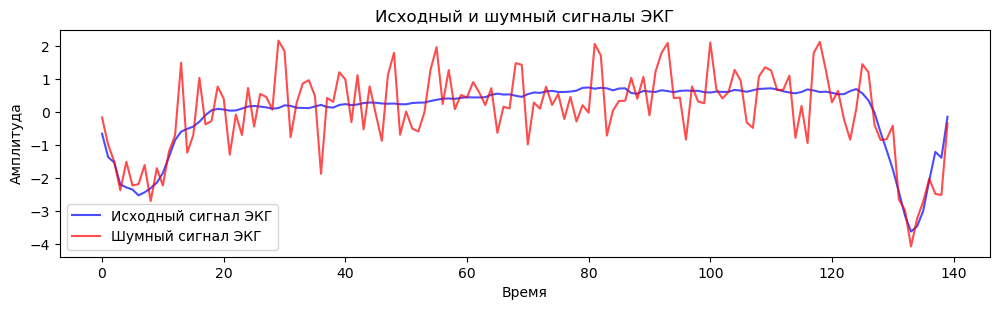

In [5]:
# Построение исходного и шумного сигналов ЭКГ
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(ecg_signal, 'b', alpha=0.7, label='Исходный сигнал ЭКГ')
plt.plot(noisy_ecg_signal, 'r', alpha=0.7, label='Шумный сигнал ЭКГ')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.title('Исходный и шумный сигналы ЭКГ')
plt.legend()

In [6]:
# Декомпозиция шумного сигнала ЭКГ с использованием DWT
wavelet = 'db4'
level = 4
coeffs = pywt.wavedec(noisy_ecg_signal, wavelet, level=level)

In [7]:
# Применение пороговой обработки коэффициентов вейвлета для удаления шума
threshold = 0.2
coeffs_thresh = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]


In [8]:
# Проверка наличия сигнала без шума
signal_energy = np.sum(np.square(ecg_signal))
noise_energy = np.sum(np.square(noise))
clean_signal_energy = np.sum(np.square(coeffs_thresh[-1]))
snr_per_level = [(signal_energy - noise_energy) / noise_energy for c in coeffs_thresh[:-1]]
snr_threshold = 3
if any(snr > snr_threshold for snr in snr_per_level):
    print("Сигнал без шума обнаружен.")
else:
    print("Сигнал без шума не обнаружен.")

Сигнал без шума не обнаружен.


Мы используем энергию сигналов для проверки, потому что энергия - это полезная мера для оценки интенсивности сигнала по сравнению с шумом. Когда мы применяем преобразование, такое как ДВП (Дискретное Вейвлет-Преобразование), чтобы удалить шум из сигнала, мы ожидаем, что энергия результирующего сигнала, после удаления шума, будет значительно выше, чем энергия шума.

Путем вычисления энергии исходного сигнала и шума мы можем сравнить остаточную энергию сигнала после удаления шума с энергией исходного шума. Если остаточная энергия значительно превышает энергию шума, мы можем сделать вывод, что сигнал был эффективно очищен от шума.

Таким образом, при проверке наличия шума в сигнале после применения методов удаления шума, таких как фильтрация на основе вейвлетов, сравнение энергий может дать нам эффективный способ определить, достаточно ли сигнал значим по сравнению с исходным шумом.

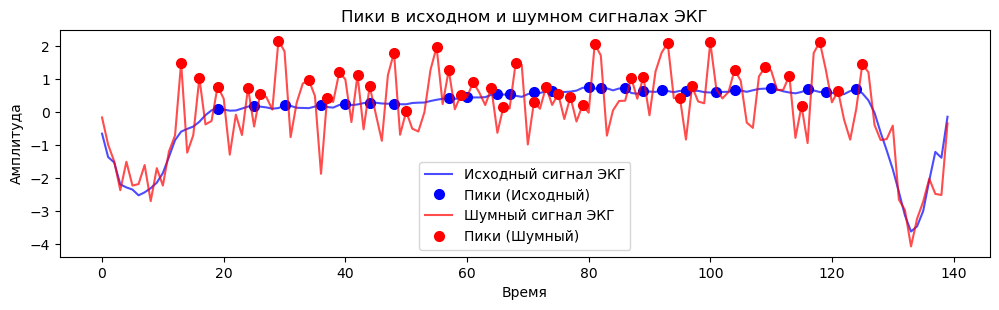

In [9]:
# Построение пиков для исходного и шумного сигналов ЭКГ
# Построение графиков
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 2)
peaks_original, _ = find_peaks(ecg_signal, height=0)
peaks_noisy, _ = find_peaks(noisy_ecg_signal, height=0)
plt.plot(ecg_signal, 'b', alpha=0.7, label='Исходный сигнал ЭКГ')
plt.plot(peaks_original, ecg_signal[peaks_original], 'bo', markersize=7, label='Пики (Исходный)')
plt.plot(noisy_ecg_signal, 'r', alpha=0.7, label='Шумный сигнал ЭКГ')
plt.plot(peaks_noisy, noisy_ecg_signal[peaks_noisy], 'ro', markersize=7, label='Пики (Шумный)')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.title('Пики в исходном и шумном сигналах ЭКГ')
plt.legend()

In [10]:

# Восстановление денормализованного сигнала ЭКГ с использованием обратного IDWT
denoised_ecg_signal = pywt.waverec(coeffs_thresh, wavelet)

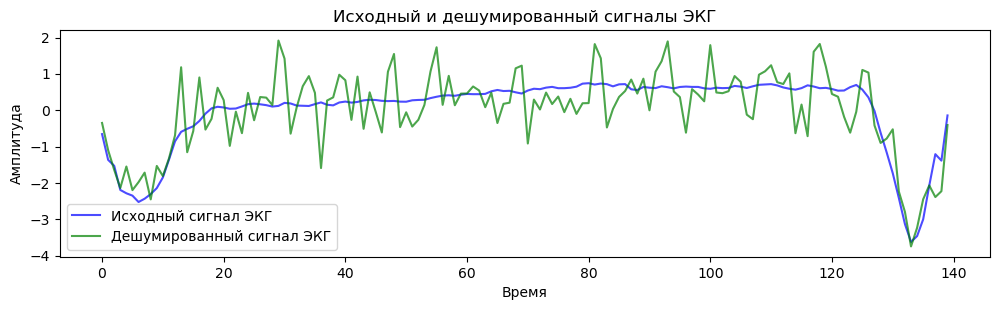

In [11]:
# Построение исходного и денормализованного сигналов ЭКГ
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 3)
plt.plot(ecg_signal, 'b', alpha=0.7, label='Исходный сигнал ЭКГ')
plt.plot(denoised_ecg_signal, 'g', alpha=0.7, label='Дешумированный сигнал ЭКГ')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.title('Исходный и дешумированный сигналы ЭКГ')
plt.legend()

In [12]:
# Расчет среднеквадратичной ошибки между исходным и денормализованным сигналами
mse = mean_squared_error(ecg_signal, denoised_ecg_signal)
print("Среднеквадратическая ошибка (MSE) между исходным сигналом и сигналом с шумоподавлением:", mse)

Среднеквадратическая ошибка (MSE) между исходным сигналом и сигналом с шумоподавлением: 0.44335213824564923
